In [1]:
import warnings
warnings.filterwarnings('ignore')

# Body Fat - Model

In this notebook we will:

    * create a null model for the target variable, body fat, with error bounds.
    * build and evaluate a linear model predicting body fat
    * evaluate and compare both models
    * make predictions using our linear model

In [2]:
import numpy as np
import random as random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from pprint import pprint
import sqlite3
import models 

sns.set(style="whitegrid")

## Null Model

In body_fat_explore.ipynb, we conducted an EDA of our target variable, BodyFat, which is a numeric, ratio scaled variable measuring the body fat percentage of an individual. In this section, we will create the null model and error bounds, postulate the data generating story, and create a distributional model.

### Mean Model (or Null Model)

We would like to predict the probability of a certain body fat percentage. We would like to penalize overestimates and underestimates the same. We would also like to penalize large errors more than small errors.
This means we should use the mean which minimizes MSE loss.

First, we will download the data and make sure it's been uploaded correctly. 

In [3]:
con = sqlite3.connect('bodyfat.db')

In [4]:
query = """
SELECT BodyFat
FROM Body_Fat2
"""
bodyfat = pd.DataFrame(con.execute(query), columns = ["BodyFat"])

We should have 251 non null rows.

In [5]:
bodyfat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BodyFat  251 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


To refresh our memory, let's replot the data

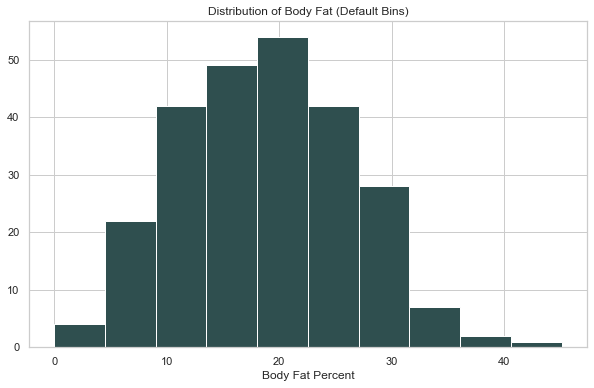

In [6]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(bodyfat, color="darkslategray")
axes.set_title("Distribution of Body Fat (Default Bins)")
axes.set_xlabel("Body Fat Percent")

plt.show()
plt.close()

Again we can see the body fat is fairly symmetric with perhaps a right skew. As such, we can use a normal distribution to approximate it's distribution.

The mean body fat is:

In [7]:
bodyfat_predict = np.mean(bodyfat.BodyFat)
bodyfat_predict

18.835458167330682

Looking at random men in this sample, we can predict that a given person will have 18.8% body fat.

What about the error bounds?
The standard deviation of body fat percentage is:

In [8]:
np.std(bodyfat.BodyFat)

7.7553617032765425

Since body fat distribution is approximately normal and symmetric, we will use the typical the error bounds of 1.96 to cover 95% of the data. 

In [9]:
bodyfat_error = np.std(bodyfat.BodyFat)*1.96
bodyfat_error

15.200508938422024

In [10]:
bodyfat_predict, bodyfat_predict - bodyfat_error, bodyfat_predict + bodyfat_error

(18.835458167330682, 3.634949228908658, 34.035967105752704)

We predict that a (random) man will have 18.8% BF (on average) with an error of up to 15.2% 95% of the time, ranging from 3.6% to 34%.

### Data Generating Story

We suspect that Body Fat percentage is determined by a number of factors including environment, genetics, food, epigenetics, and exercise. We should therefore expect its distribution to approximate a normal one, bearing in mind we cannot have a negative body fat percentage.  

### Distributional Model

We don't just want to predict the typical body fat percent of a male in our sample, therefore, we'll use a mathematical distribution as a model.
We can then use the distributional model to make some predictions about body fat percentages.
Based on the EDA and the discussion of the Data Generating Story, a Normal distribution is likely to be a good model for the data.
We've already calculated the first and second moments of the data.
The Normal distribution has two pararmeters which are, respectively, the first and second moments of the empirical distribution.

Let's plot the Normal distribution over the data:

In [11]:
from scipy.stats import norm

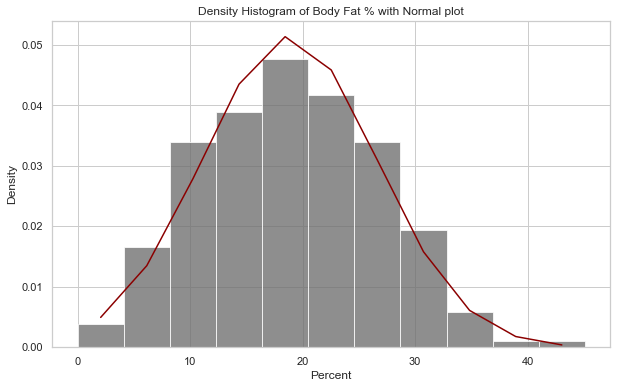

In [12]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(bodyfat.BodyFat, color="DimGray", density=True, bins=11, alpha=0.75)
axes.set_xlabel( "Percent")
axes.set_ylabel( "Density")
axes.set_title("Density Histogram of Body Fat % with Normal plot")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

bodyfat_mean = np.mean(bodyfat.BodyFat)
bodyfat_std  = np.std(bodyfat.BodyFat)
ys = [norm.pdf( k, loc=bodyfat_mean, scale=bodyfat_std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

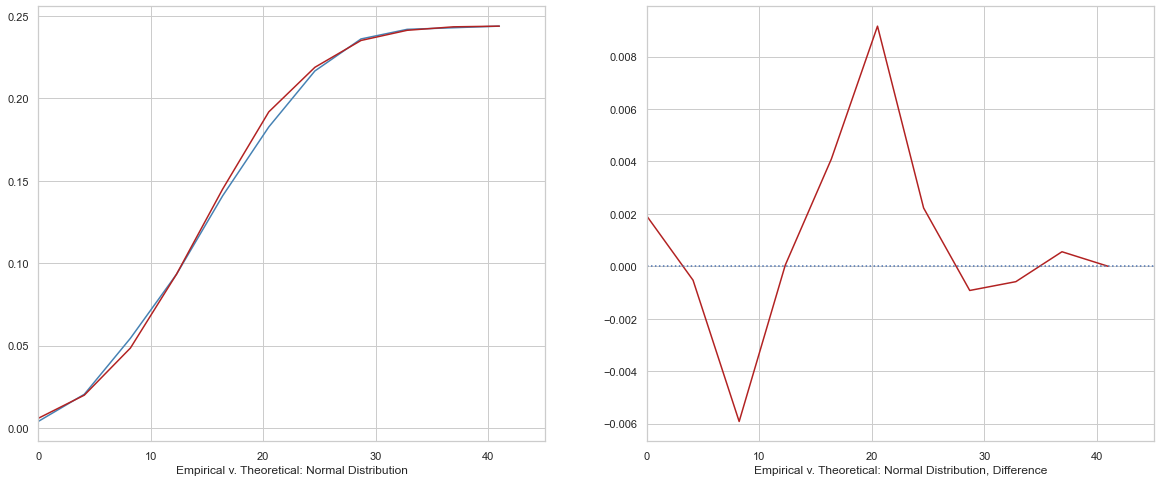

In [13]:
figure = plt.figure(figsize=(20, 8))

bf_mn = np.min(bodyfat.BodyFat)
bf_mx = np.max(bodyfat.BodyFat)
mean = np.mean(bodyfat.BodyFat)
std = np.std(bodyfat.BodyFat)

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(bodyfat.BodyFat, bins=11, density=True)
cumulative = np.cumsum(values)
axes.plot(base[:-1], cumulative, color="steelblue")
axes.set_xlim((bf_mn, bf_mx))

sampled_data = [mean + r * std for r in np.random.standard_normal(10000)]
values2, base = np.histogram(sampled_data, bins=base, density=True)
cumulative2 = np.cumsum(values2)
axes.plot( base[:-1], cumulative2, color="firebrick")
axes.set_xlim((bf_mn, bf_mx))
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
axes.set_xlim((bf_mn, bf_mx))
axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution, Difference")

plt.show()
plt.close()

The blue line (Normal distribution) looks like a pretty good (smooth) approximation of the red line (Empirical distribution).

The model will predict more men with body fat near the mean, and fewer people that are between 5% and 15%, but by a miniscule amount from .006% to .004%. 

## Linear Models

### Build the Model

Let's review the EDA.

The data contains a 13 variables that all follow (or approximate) a normal distribution. 

* Age - Normal distribution, approximates US population triangle
* Weight (lbs)  - Normal distribution, right skew
* Height (in)  - Normal distribution, approximates US distribution 
* Neck Circumference (cm) - Normal distribution, right skew
* Chest Circumference (cm) - Normal distribution, right skew 
* Abdomen Circumference (cm) - Normal distribution, right skew
* Hip Circumference (cm) - Normal distribution, right skew    
* Thigh Circumference (cm) - Normal distribution, right skew   
* Knee Circumference (cm) - Normal distribution, right skew   
* Ankle Circumference (cm) - Normal distribution, right skew  
* Biceps Circumference (cm)  - Normal distribution, right skew    
* Forearm Circumference (cm) - Normal distribution, right skew     
* Wrist Circumference (cm )- Normal distribution, right skew 

*All of the skews consist off long tails on the right*

We also have many features:

* Abdomen Circumference to Height (ATH)       
* Abdomen Circumference to Hip (aka Waist to Hip) (ABTH)
* BMI
* Chest Circumference to Height (CTH)
* Hip Circumference to Height (HTH)
* Thigh Circumference to Height (TTH)
* Knee Circumference to Height (KTH)
* Biceps Circumference to Height (BTH)
* Neck Circumference to Height (NTH)
* Forearm Circumference to Height (FTH)
* Wrist Circumference to Height (WTH)
* Ankle Circumference to Height (AKTH)
    
For the features, there's nothing that particularly stands out as needing our attention.

Let's load the data:

In [14]:
query = """
SELECT Age, Weight, Height, Neck, Chest, Abdomen, Hip, Thigh, Knee, Ankle, Biceps, Forearm,
        Wrist, ATH, ABTH, BMI, CTH, HTH, TTH, KTH, BTH, NTH, FTH, WTH, AKTH
FROM Body_Fat2
"""
data = pd.DataFrame(con.execute(query), columns = ["Age", "Weight", "Height", "Neck", "Chest", 
                                                   "Abdomen", "Hip", "Thigh", "Knee", "Ankle", 
                                                   "Biceps", "Forearm", "Wrist", "ATH", "ABTH", 
                                                   "BMI", "CTH", "HTH", "TTH", "KTH", "BTH", 
                                                   "NTH", "FTH", "WTH", "AKTH"])
bodyfat = pd.concat([bodyfat, data], axis = 1)
bodyfat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BodyFat  251 non-null    float64
 1   Age      251 non-null    int64  
 2   Weight   251 non-null    float64
 3   Height   251 non-null    float64
 4   Neck     251 non-null    float64
 5   Chest    251 non-null    float64
 6   Abdomen  251 non-null    float64
 7   Hip      251 non-null    float64
 8   Thigh    251 non-null    float64
 9   Knee     251 non-null    float64
 10  Ankle    251 non-null    float64
 11  Biceps   251 non-null    float64
 12  Forearm  251 non-null    float64
 13  Wrist    251 non-null    float64
 14  ATH      251 non-null    float64
 15  ABTH     251 non-null    float64
 16  BMI      251 non-null    float64
 17  CTH      251 non-null    float64
 18  HTH      251 non-null    float64
 19  TTH      251 non-null    float64
 20  KTH      251 non-null    float64
 21  BTH      251 non

Let's review our pairwise EDA with the target variable, body fat:

* Age - no relationship
* Weight - definite positive, linear relationship
* Height - no relationship 
* Neck Circumference - definite positive relationship, possibly nonlinear though unlikely
* Chest Circumference - definite positive, linear relationship
* Abdomen Circumference - definite positive, linear relationship
* Hip Circumference - definite positive, linear relationship
* Thigh Circumference - definite positive, linear relationship  
* Knee Circumference - definite positive, linear relationship      
* Ankle Circumference - no relationship or hard to see 
* Biceps Circumference - weak positive, linear relationship    
* Forearm Circumference - weak positive, linear relationship     
* Wrist Circumference - weak positive, linear relationship    

And for the derived features:
* Abdomen Circumference to Height - definite positive, linear relationship   
* Abdomen Circumference to Hip - definite positive, linear relationship
* BMI - definite positive, linear relationship
* Chest Circumference to Height - definite positive, nonlinear relationship
* Hip Circumference to Height - definite positive, nonlinear relationship
* Thigh Circumference to Height - definite positive, nonlinear relationship
* Knee Circumference to Height - weak positive, nonlinear relationship
* Biceps Circumference to Height - definite positive, linear relationnship
* Neck Circumference to Height - definite positive, possibly nonlinear though unlikley
* Forearm Circumference to Height - very weak positive, linear relationship
* Wrist Circumference to Height - weak positive, linear relationship
* Ankle Circumference to Height - very weak positive or hard to see   

Since we've decided to use a linear model, it is much more important to look at the correlation coefficients between each variable and the target. We'll use the helper function available in Lab 10.

In [15]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    df = pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})
    return df.sort_values(by = "r", ascending = False)

In [16]:
correlations(bodyfat, "BodyFat", ["Age", "Weight", "Height", "Neck", "Chest", 
                                                   "Abdomen", "Hip", "Thigh", "Knee", "Ankle", 
                                                   "Biceps", "Forearm", "Wrist", "ATH", "ABTH", 
                                                   "BMI", "CTH", "HTH", "TTH", "KTH", "BTH", 
                                                   "NTH", "FTH", "WTH", "AKTH"])

,feature,r,rho
13,ATH,0.825028,0.828111
5,Abdomen,0.800852,0.806139
14,ABTH,0.774810,0.775936
15,BMI,0.715955,0.715689
16,CTH,0.708139,0.683683
4,Chest,0.684783,0.661329
17,HTH,0.675899,0.668377
6,Hip,0.606416,0.596797
18,TTH,0.602889,0.584981
1,Weight,0.593961,0.598986


There are some interesting results here:

1. height - there is absolutely no relationship by itself but as soon as we "scale" some body circumferences some go from having mild correlations to slightly stronger correlations.
2. age - also a poor correlator
3. ankle, AKTH, wrist, forearm, WTH, FTH, neck, biceps, knee, BTH, NTH - are the weaker relationships. When scaled by height they improve but their overall correlation is less than 60%
4. thigh, KTH, weight, TTH, Hip, HTH, Chest, CTH - are all moderate correlators (less than 70%)
5. BMI, ABTH, Abdomen, and ATH - are all the strongest correlators (70% and up)
6. All the pearson's and spearman's are about the same, suggesting that if a relationship exists its linear. 

There are no variables that have a large difference in their Pearson's and Spearman's correlation. 

Before estimating any linear models, let's look at the Null model (the mean):

In [17]:
bodyfat.BodyFat.describe()

count    251.000000
mean      18.835458
std        7.770857
min        0.000000
25%       12.700000
50%       19.000000
75%       24.550000
max       45.100000
Name: BodyFat, dtype: float64

The lowest body fat is 0% and the highest is 45%. The mean is 18% with a standard deviation of 7.7708%. 

This is what we're trying to beat by creating a linear regression model (of course, we may also be interested in explanation as well).

We have a long ride ahead of so let's begin.

The best place to start, in general, is the "all in" model. Let's just begin with the simple measurements (without the features). We have domain knowledge and some statistics to support the inclusion of all the variables.

In [18]:
random.seed(1)
model = """BodyFat ~ Age + Weight + Height + Neck +Chest +Abdomen +Hip + Thigh +Knee +Ankle+
        Biceps + Forearm + Wrist"""
result1 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-12.50,-54.12,45.36
Age,$\beta_{1}$,0.05,0.00,0.10
Weight,$\beta_{2}$,-0.09,-0.21,0.08
Height,$\beta_{3}$,-0.03,-0.22,0.11
Neck,$\beta_{4}$,-0.43,-0.92,-0.06
Chest,$\beta_{5}$,-0.06,-0.30,0.14
Abdomen,$\beta_{6}$,0.93,0.75,1.08
Hip,$\beta_{7}$,-0.22,-0.55,0.07
Thigh,$\beta_{8}$,0.23,-0.07,0.43


The correlation coefficient is 74% which is pretty good. The error ($\sigma$) has been cut almost in half compared to the Null model 7.77 to 4.07.

What about the coefficients?

* The intercept isn't particularly interesting here because no such person exists.

There are a lot of coefficients so let's separate them into categories.

Strong Support (CI does not include 0):
* Age (+)
* Abdomen (+)
* Forearm (+)
* Wrist (-)
* Neck (-)

Mixed Support
* Weight (-)
* Height (-)
* Chest (-)
* Hip (-)
* Knee (0)
* Ankle (+)
* Biceps (+)
* Thigh (+)

A lot of these variables don't seem to make much sense, especially all the negative correlators. I suspect there is so much multicolinearity in this model, that we're getting weird values. Before moving on, let's check the residuals using the code provided in fundamentals:

In [19]:
def plot_residuals(data, result, variables):
    figure = plt.figure(figsize=(20,20))

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(data[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

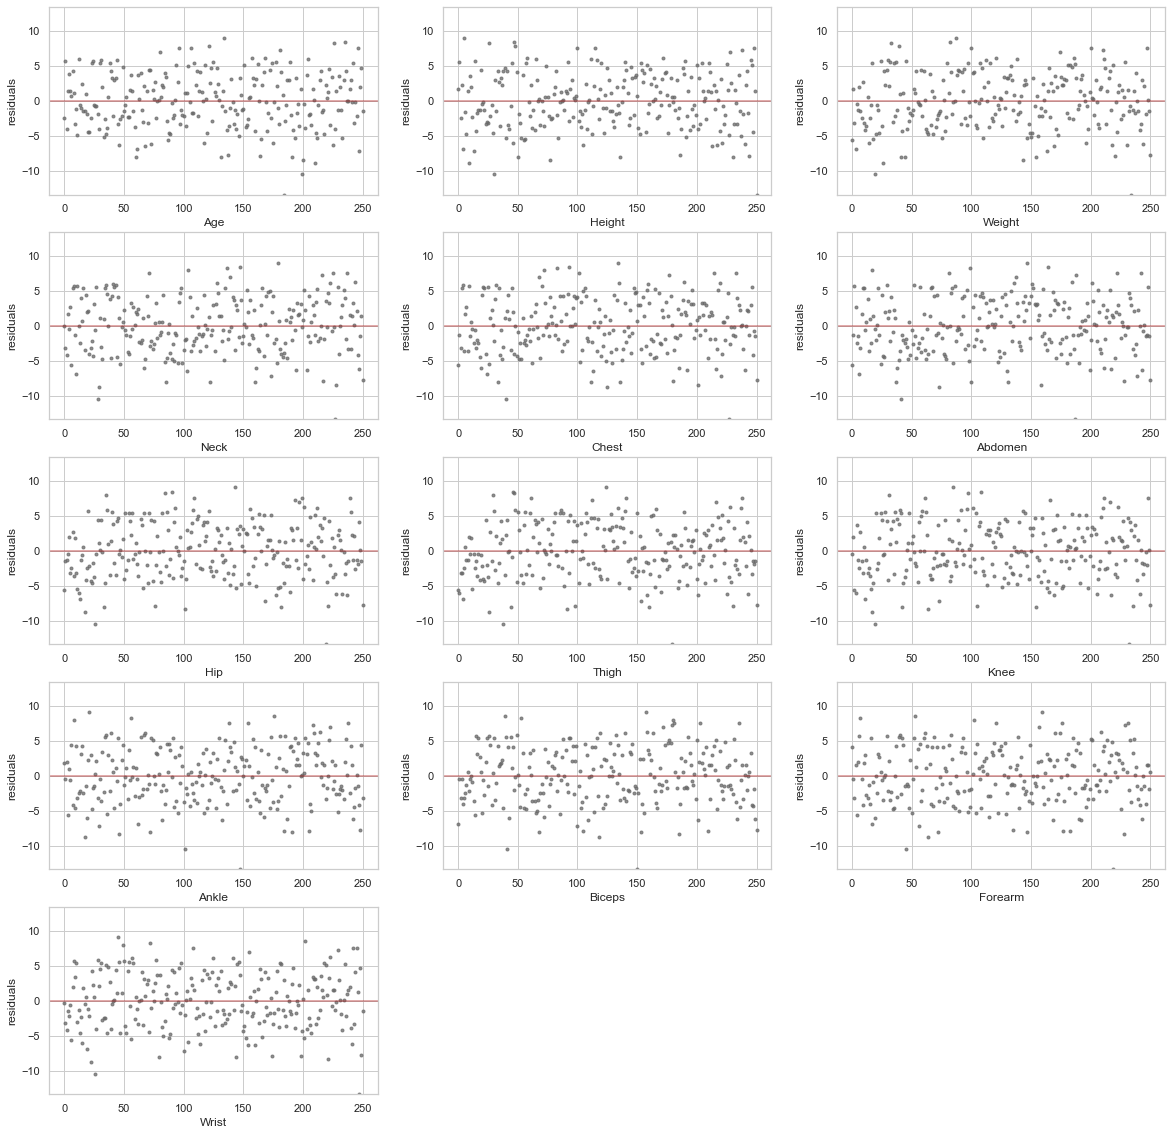

In [20]:
result1_residuals = plot_residuals(bodyfat, result1, ["Age", "Height", "Weight", "Neck",
                                                  "Chest", "Abdomen", "Hip", "Thigh",
                                                  "Knee", "Ankle", "Biceps", "Forearm",
                                                  "Wrist"])

We detect no issues with any of the variables. They all seem to be centered around zero with constant variance. It doesn't seem we would need to transform any to confirm to OLS assumptions. Now let's check the overall residual.

In [21]:
def plot_residual(result):
    figure = plt.figure(figsize=(20,6))

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    axes = figure.add_subplot(1,1,1)
    n = result["n"]
    axes.scatter( result["y_hat"], result["residuals"], marker="o", color="darkslategray")
       
    axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
    axes.set_ylim((-limits, limits))
    axes.set_ylabel("residuals")
    axes.set_xlabel("fitted value")

    plt.show()
    plt.close()

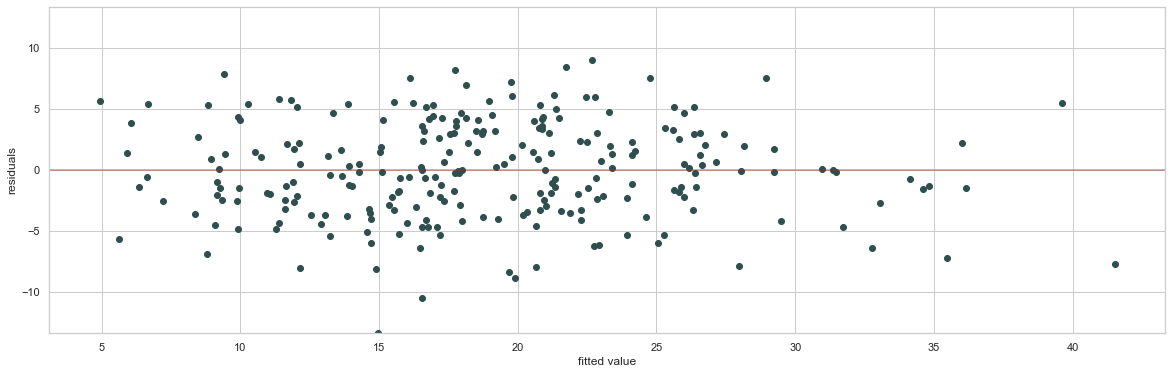

In [22]:
plot_residual(result1)

It seems we have constant variance with errors centered around 0 as well. 

In our EDA we scaled many of the variables by the persons height in order to account for size differences not due to body fat but due to the body frame. We will go through every variable one by one and see if the scaled version decreases $\sigma$. If so, we will use the scaled version and if not we will use the regular version. 

Let's begin by scaling Abdomen by Height:

In [23]:
random.seed(2)
model = """BodyFat ~ Age + Weight + Height + Neck +Chest + ATH +Hip + Thigh +Knee +Ankle+
        Biceps + Forearm + Wrist"""
result2 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-89.42,-139.39,-32.14
Age,$\beta_{1}$,0.05,-0.01,0.11
Weight,$\beta_{2}$,-0.07,-0.19,0.08
Height,$\beta_{3}$,0.43,0.22,0.58
Neck,$\beta_{4}$,-0.43,-0.78,-0.06
Chest,$\beta_{5}$,-0.10,-0.27,0.08
ATH,$\beta_{6}$,165.25,133.59,196.95
Hip,$\beta_{7}$,-0.27,-0.51,0.06
Thigh,$\beta_{8}$,0.23,0.05,0.48


In [24]:
print(models.adjusted_r_squared(result1))
print(models.adjusted_r_squared(result2))

0.7233096534162536
0.7275944659343915


We can see that scaling Abdomen decresed $\sigma$ from 4.07 to 4.04, kept $R^2$ at .74 and increased *adjusted* $R^2$ from .727 to .723. We will keep this scaled version. Now let's try changing Chest to Chest to Height Ratio.

In [25]:
random.seed(3)
model = """BodyFat ~ Age + Weight + Height + Neck + CTH + ATH +Hip + Thigh +Knee +Ankle+
        Biceps + Forearm + Wrist"""
result3 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-82.10,-142.10,-3.62
Age,$\beta_{1}$,0.05,0.00,0.12
Weight,$\beta_{2}$,-0.07,-0.20,0.10
Height,$\beta_{3}$,0.38,0.08,0.57
Neck,$\beta_{4}$,-0.43,-0.84,-0.07
CTH,$\beta_{5}$,-15.40,-58.44,22.10
ATH,$\beta_{6}$,165.21,132.02,192.55
Hip,$\beta_{7}$,-0.27,-0.51,0.03
Thigh,$\beta_{8}$,0.23,-0.01,0.45


In [26]:
print(models.adjusted_r_squared(result2))
print(models.adjusted_r_squared(result3))

0.7275944659343915
0.7274343776018182


We can see that scaling Chest kept $\sigma$ unchanged 4.04, kept $R^2$ at .74 and  *adjusted* $R^2$ at .727. We will keep this unscaled version. Now let's try changing Hip to Hip/Height

In [27]:
random.seed(4)
model = """BodyFat ~ Age + Weight + Height + Neck + Chest + ATH + HTH + Thigh +Knee +Ankle+
        Biceps + Forearm + Wrist"""
result4 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-70.24,-143.40,-16.30
Age,$\beta_{1}$,0.05,-0.01,0.10
Weight,$\beta_{2}$,-0.08,-0.19,0.06
Height,$\beta_{3}$,0.30,0.09,0.58
Neck,$\beta_{4}$,-0.42,-0.85,-0.03
Chest,$\beta_{5}$,-0.09,-0.33,0.08
ATH,$\beta_{6}$,165.35,138.70,195.12
HTH,$\beta_{7}$,-41.72,-79.55,1.78
Thigh,$\beta_{8}$,0.22,-0.06,0.50


In [28]:
print(models.adjusted_r_squared(result2))
print(models.adjusted_r_squared(result4))

0.7275944659343915
0.7266906677830176


Scaling hip increased $\sigma$ to 4.05, kept $R^2$ at .74 and decreased *adjusted* $R^2$ to .726. We will keep the unscaled version. Now let's try changing Thigh to Thigh/Height

In [29]:
random.seed(5)
model = """BodyFat ~ Age + Weight + Height + Neck + Chest + ATH + Hip + TTH +Knee +Ankle+
        Biceps + Forearm + Wrist"""
result5 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result5)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-102.58,-143.18,-44.73
Age,$\beta_{1}$,0.05,-0.00,0.10
Weight,$\beta_{2}$,-0.06,-0.17,0.07
Height,$\beta_{3}$,0.50,0.24,0.70
Neck,$\beta_{4}$,-0.44,-0.75,-0.08
Chest,$\beta_{5}$,-0.10,-0.34,0.05
ATH,$\beta_{6}$,164.71,133.54,196.16
Hip,$\beta_{7}$,-0.28,-0.51,-0.02
TTH,$\beta_{8}$,43.34,2.70,78.06


In [30]:
print(models.adjusted_r_squared(result2))
print(models.adjusted_r_squared(result5))

0.7275944659343915
0.7279134158270348


Scaling thigh kept $\sigma$ at 4.04, $R^2$ at .74 and *adjusted* $R^2$ to .727. Because the CI has narrowed for the $\sigma$, however, we will keep the scaled version. Now let's try changing Knee to Knee/Height

In [31]:
random.seed(6)
model = """BodyFat ~ Age + Weight + Height + Neck + Chest + ATH + Hip + TTH + KTH +Ankle+
        Biceps + Forearm + Wrist"""
result6 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-104.89,-164.26,-29.91
Age,$\beta_{1}$,0.05,0.01,0.10
Weight,$\beta_{2}$,-0.06,-0.18,0.08
Height,$\beta_{3}$,0.52,0.23,0.76
Neck,$\beta_{4}$,-0.43,-0.86,-0.03
Chest,$\beta_{5}$,-0.10,-0.36,0.07
ATH,$\beta_{6}$,164.69,139.49,194.76
Hip,$\beta_{7}$,-0.28,-0.52,-0.04
TTH,$\beta_{8}$,43.12,2.83,90.14


In [32]:
print(models.adjusted_r_squared(result5))
print(models.adjusted_r_squared(result6))

0.7279134158270348
0.7279283901897529


As before we see no improvement in any metric, so we will keep the unscaled version. Now we test the ankle to height.

In [33]:
random.seed(7)
model = """BodyFat ~ Age + Weight + Height + Neck + Chest + ATH + Hip + TTH + Knee + AKTH +
        Biceps + Forearm + Wrist"""
result7 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result7)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-108.19,-151.27,-53.58
Age,$\beta_{1}$,0.05,-0.00,0.09
Weight,$\beta_{2}$,-0.07,-0.20,0.08
Height,$\beta_{3}$,0.53,0.31,0.71
Neck,$\beta_{4}$,-0.43,-0.89,0.02
Chest,$\beta_{5}$,-0.10,-0.32,0.06
ATH,$\beta_{6}$,164.72,141.88,188.17
Hip,$\beta_{7}$,-0.28,-0.51,0.00
TTH,$\beta_{8}$,43.31,-12.79,80.67


In [34]:
print(models.adjusted_r_squared(result5))
print(models.adjusted_r_squared(result7))

0.7279134158270348
0.7280513625517435


As before we see no improvement in any metric, so we will keep the unscaled version. Now we test the biceps to height.

In [35]:
random.seed(8)
model = """BodyFat ~ Age + Weight + Height + Neck + Chest + ATH + Hip + TTH + Knee + Ankle +
        BTH + Forearm + Wrist"""
result8 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result8)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-110.16,-171.45,-46.69
Age,$\beta_{1}$,0.05,0.01,0.11
Weight,$\beta_{2}$,-0.06,-0.20,0.08
Height,$\beta_{3}$,0.55,0.31,0.79
Neck,$\beta_{4}$,-0.44,-0.75,-0.00
Chest,$\beta_{5}$,-0.10,-0.29,0.07
ATH,$\beta_{6}$,164.68,138.48,194.00
Hip,$\beta_{7}$,-0.28,-0.53,-0.00
TTH,$\beta_{8}$,42.89,-2.93,89.04


In [36]:
print(models.adjusted_r_squared(result5))
print(models.adjusted_r_squared(result8))

0.7279134158270348
0.7281217656664962


We've decreased $\sigma$ from 4.04 to 4.03, but $R^2$ is still the same (.74), although *adjusted* $R^2$ has slightly increased to .728. We will keep the scaled biceps. Let's try scaling forearm.

In [37]:
random.seed(9)
model = """BodyFat ~ Age + Weight + Height + Neck + Chest + ATH + Hip + TTH + Knee + Ankle +
        BTH + FTH + Wrist"""
result9 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result9)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-120.06,-172.28,-57.70
Age,$\beta_{1}$,0.05,0.01,0.11
Weight,$\beta_{2}$,-0.06,-0.18,0.07
Height,$\beta_{3}$,0.60,0.36,0.81
Neck,$\beta_{4}$,-0.44,-0.86,-0.11
Chest,$\beta_{5}$,-0.10,-0.31,0.09
ATH,$\beta_{6}$,164.48,131.44,192.19
Hip,$\beta_{7}$,-0.28,-0.50,0.01
TTH,$\beta_{8}$,42.95,-7.41,81.47


In [38]:
print(models.adjusted_r_squared(result8))
print(models.adjusted_r_squared(result9))

0.7281217656664962
0.7281497765920402


We observe no improvement in the model metrics, however, FTH's CI is now completely positive, so we will use the scaled version. Next we can try transforming wrist. 

In [39]:
random.seed(10)
model = """BodyFat ~ Age + Weight + Height + Neck + Chest + ATH + Hip + TTH + Knee + Ankle +
        BTH + FTH + WTH"""
result10 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result10)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-91.34,-142.65,-26.93
Age,$\beta_{1}$,0.05,0.01,0.11
Weight,$\beta_{2}$,-0.07,-0.16,0.06
Height,$\beta_{3}$,0.44,0.14,0.66
Neck,$\beta_{4}$,-0.44,-0.76,-0.03
Chest,$\beta_{5}$,-0.10,-0.30,0.08
ATH,$\beta_{6}$,165.02,133.17,186.12
Hip,$\beta_{7}$,-0.28,-0.57,0.00
TTH,$\beta_{8}$,43.14,-5.25,87.59


In [40]:
print(models.adjusted_r_squared(result9))
print(models.adjusted_r_squared(result10))

0.7281497765920402
0.7279726608185259


Again we don't see any improvement in the metrics so we will keep the unscaled version. 

Now, let's test Neck to Height.

In [41]:
random.seed(11)
model = model = """BodyFat ~ Age + Weight + Height + NTH + Chest + ATH + Hip + TTH + Knee + Ankle +
        BTH + Forearm + Wrist"""
result11 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result11)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-95.91,-149.64,-28.86
Age,$\beta_{1}$,0.05,0.01,0.09
Weight,$\beta_{2}$,-0.07,-0.17,0.09
Height,$\beta_{3}$,0.46,0.22,0.69
NTH,$\beta_{4}$,-74.71,-136.50,-14.89
Chest,$\beta_{5}$,-0.10,-0.31,0.07
ATH,$\beta_{6}$,165.15,134.44,190.06
Hip,$\beta_{7}$,-0.28,-0.52,-0.05
TTH,$\beta_{8}$,42.97,2.58,89.97


In [42]:
print(models.adjusted_r_squared(result9))
print(models.adjusted_r_squared(result11))

0.7281497765920402
0.7278512159255285


Again changing Neck to Neck to Heigh does not improve $\sigma$ or the $R^2$'s. As a last hail mary, let's see if adding all the scaled versions improves $\sigma$.

In [43]:
random.seed(12)
model = model = """BodyFat ~ Age + Weight + Height + NTH + CTH + ATH + HTH + TTH + KTH + AKTH +
        BTH + FTH + WTH"""
result12 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result12)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-59.73,-115.40,26.42
Age,$\beta_{1}$,0.05,0.01,0.11
Weight,$\beta_{2}$,-0.09,-0.17,0.04
Height,$\beta_{3}$,0.24,-0.11,0.47
NTH,$\beta_{4}$,-72.85,-147.78,-5.24
CTH,$\beta_{5}$,-14.05,-48.96,16.66
ATH,$\beta_{6}$,165.48,127.90,191.94
HTH,$\beta_{7}$,-41.28,-84.91,-3.04
TTH,$\beta_{8}$,41.53,5.48,84.49


In [44]:
print(models.adjusted_r_squared(result9))
print(models.adjusted_r_squared(result12))

0.7281497765920402
0.726785133687134


Scaling all the measurements doesn't necessarily improve the model. So we will use the model that has scaled the abdomen, thigh, bicep and forearm only. Our tentative model therefore is model 9. 

Let's add the two other interactions that very strongly correlated with body fat, BMI and Abdomen to Hip (or Waist to Hip) ratio. We will add them one at a time.

In [45]:
random.seed(13)
model = """BodyFat ~ Age + Weight + Height + Neck + Chest + ATH + Hip + TTH + Knee + Ankle +
        BTH + FTH + Wrist + BMI"""
result13 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result13)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-190.30,-305.37,-78.94
Age,$\beta_{1}$,0.06,-0.01,0.11
Weight,$\beta_{2}$,-0.27,-0.59,0.02
Height,$\beta_{3}$,1.03,0.44,1.62
Neck,$\beta_{4}$,-0.42,-0.78,-0.06
Chest,$\beta_{5}$,-0.13,-0.38,0.02
ATH,$\beta_{6}$,156.01,120.54,189.20
Hip,$\beta_{7}$,-0.32,-0.60,-0.06
TTH,$\beta_{8}$,41.46,6.94,84.19


In [46]:
print(models.adjusted_r_squared(result9))
print(models.adjusted_r_squared(result13))

0.7281497765920402
0.7301012058637775


Surprisingly, adding BMI decreases sigma by .02, and increases $R^2$ to .75, and increases *adjusted* $R^2$ to .73. We will add it to our model. 

Lastly, let's add Waist to Hip ratio.

In [47]:
random.seed(14)
model = """BodyFat ~ Age + Weight + Height + Neck + Chest + ATH + Hip + TTH + Knee + Ankle +
        BTH + FTH + Wrist + BMI + ABTH"""
result14 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result14)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-260.68,-444.67,-93.97
Age,$\beta_{1}$,0.06,-0.00,0.12
Weight,$\beta_{2}$,-0.50,-1.06,-0.06
Height,$\beta_{3}$,0.74,0.05,1.26
Neck,$\beta_{4}$,-0.45,-0.82,-0.09
Chest,$\beta_{5}$,-0.15,-0.38,0.09
ATH,$\beta_{6}$,-92.45,-364.74,156.51
Hip,$\beta_{7}$,1.01,-0.29,2.57
TTH,$\beta_{8}$,26.75,-25.20,72.43


In [48]:
print(models.adjusted_r_squared(result13))
print(models.adjusted_r_squared(result14))

0.7301012058637775
0.733755586277497


Surprisingly, adding ABTH decreases sigma by .02 to 3.99, and doesn't increase any of our $R^2$ values. It also makes Hip positive, but strangley Abdomen to Height is now negative. Chest, Neck, Wrist and Weight are still inexplicably negative. No doubt the correlation betwen ABTH and ATH is causing the issue between. Let's try removing ATH and see if that clears up some issues.

In [49]:
random.seed(15)
model = """BodyFat ~ Age + Weight + Height + Neck + Chest + Hip + TTH + Knee + Ankle +
        BTH + FTH + Wrist + BMI + ABTH"""
result15 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result15)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-234.52,-336.83,-125.70
Age,$\beta_{1}$,0.05,0.01,0.11
Weight,$\beta_{2}$,-0.41,-0.73,-0.14
Height,$\beta_{3}$,0.85,0.27,1.51
Neck,$\beta_{4}$,-0.44,-0.79,0.01
Chest,$\beta_{5}$,-0.15,-0.34,0.06
Hip,$\beta_{6}$,0.52,0.26,0.86
TTH,$\beta_{7}$,31.97,-13.52,76.39
Knee,$\beta_{8}$,0.07,-0.32,0.42


In [50]:
print(models.adjusted_r_squared(result14))
print(models.adjusted_r_squared(result15))

0.733755586277497
0.7342406502999099


Removing ATH in favor of ABTH keeps $\sigma$ at 3.99 but narrows its CI. It keeps $R^2$ the same (.75) and slightly increases *adjusted* $R^2$ to .73. 

So far we've added every possible variable, conducted some transformations, and added some interaction terms. Our tentative model is good, but we still have issues with it, to review:

Strong Support
* Age (+)
* Height (+)
* Neck (-)
* Hip (+)
* FTH (+)
* BMI (+)
* ABTH (+)
* Weight (-)
* Neck (-)
* Wrist (-)

Mixed Support 
* Chest (-)
* TTH (+)
* Knee (+)
* Ankle (+)
* BTH (+)

The signs for some of our mixed support models don't make much sense, such as Neck, Weight, Chest and Wrist. Why these would these negatively correlate with BodyFat? 

According to Douglas C Montgomery in Introduction to Linear Regression Analysis, regression coefficients may have the wrong sign for the following reasons:

1. The range of some of the regressors is too small.
2. important regressors have not been included in the model.
3. multicolinearity is present.
4. computational errors have been made. 

We can rule our 4. In the case of 1, we cannot really do anything to increase the range of the regressors as human body parts only come in a certain range of sizes. Similarly, we attempted every conceivable, legitimate interaction to no avail as the signs remained unchanged as we added regressors. This leaves us with 4. There is no doubt that all these factors correlate with each other. In effect, severe multicolinearity inflates the variances and increases the probability that one or more regression coefficients will have the wrong sign. We will attempt to minimize this by removing regressors that have unexpected signs that include 0. If the $R^2$ drops too severely, we will readd the variable and reexamine. 

We begin by removing ankle because its sign doesn't make sense and its insignificant at the moment.

In [51]:
random.seed(16)
model = """BodyFat ~ Age + Weight + Height + Neck + Chest + Hip + TTH + Knee +
        BTH + FTH + Wrist + BMI + ABTH"""
result16 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result16)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-233.69,-329.44,-143.59
Age,$\beta_{1}$,0.05,0.00,0.11
Weight,$\beta_{2}$,-0.41,-0.68,-0.17
Height,$\beta_{3}$,0.86,0.36,1.37
Neck,$\beta_{4}$,-0.46,-0.83,-0.06
Chest,$\beta_{5}$,-0.15,-0.39,0.05
Hip,$\beta_{6}$,0.50,0.25,0.76
TTH,$\beta_{7}$,31.50,-6.95,68.96
Knee,$\beta_{8}$,0.11,-0.28,0.54


In [52]:
print(models.adjusted_r_squared(result15))
print(models.adjusted_r_squared(result16))

0.7342406502999099
0.7344787428507701


Removing knee hasn't made the model worse. In fact $\sigma$ and $R^2$ are unchanged and *adjusted* $R^2$ has actually increased impercetibly. Even better, the error bounds for $\sigma$ has has gotten smaller. Examining the remaining variables, the signs haven't changed. The problematic regressors:

* Weight
* Neck
* Chest
* Wrist

Neck, Wrist and weight have strong support, indicating that we should reexamine our belief that they contribute negatively to bodyfat. More likely, there is simply too much multicolinearity and so these values are negative to compensate as stated before. Let's remove chest, since it has a negative sign and is not significant.

In [53]:
random.seed(17)
model = """BodyFat ~ Age + Weight + Height + Neck + Hip + TTH + Knee +
        BTH + FTH + Wrist + BMI + ABTH"""
result17 = models.bootstrap_linear_regression(model, data= bodyfat)
models.describe_bootstrap_lr(result17)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-231.17,-321.53,-123.14
Age,$\beta_{1}$,0.05,0.00,0.10
Weight,$\beta_{2}$,-0.41,-0.65,-0.11
Height,$\beta_{3}$,0.81,0.21,1.34
Neck,$\beta_{4}$,-0.46,-0.87,-0.06
Hip,$\beta_{5}$,0.51,0.24,0.72
TTH,$\beta_{6}$,38.47,2.34,82.41
Knee,$\beta_{7}$,0.12,-0.31,0.53
BTH,$\beta_{8}$,36.17,-11.54,88.69


In [54]:
print(models.adjusted_r_squared(result16))
print(models.adjusted_r_squared(result17))

0.7344787428507701
0.7329363572488449


Our $\sigma$ (4.00) has taken a little bit of a hit, and *adjusted* $R^2$'s have slightly decreased. Neck and Wrist are still significantly negative. 

Let's check the residuals for our model.

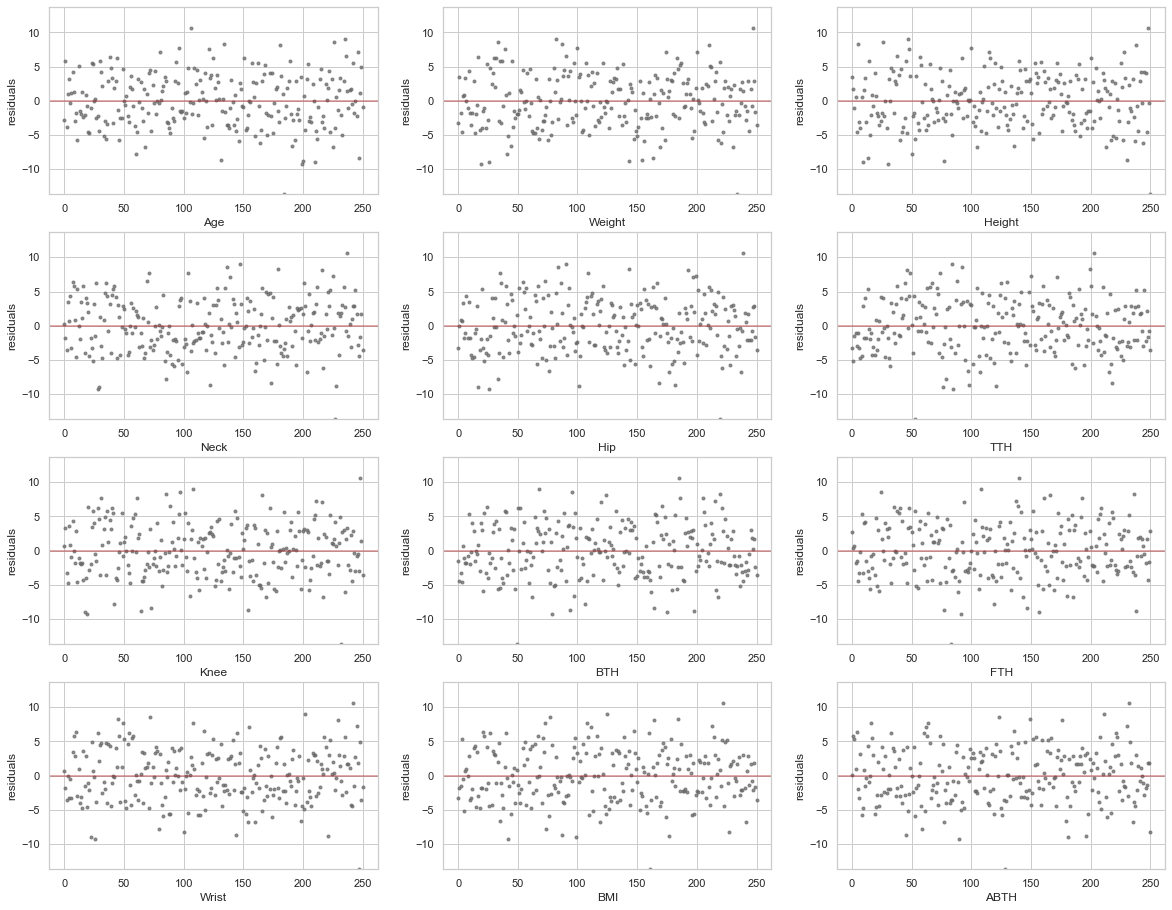

In [55]:
result17_residuals = plot_residuals(bodyfat, result17, [ "Age", "Weight", "Height", "Neck",
                                                   "Hip", "TTH", "Knee", "BTH", 
                                                   "FTH", "Wrist", "BMI", "ABTH"])

We don't see any errors with our residuals. Let's check the overall residuals.

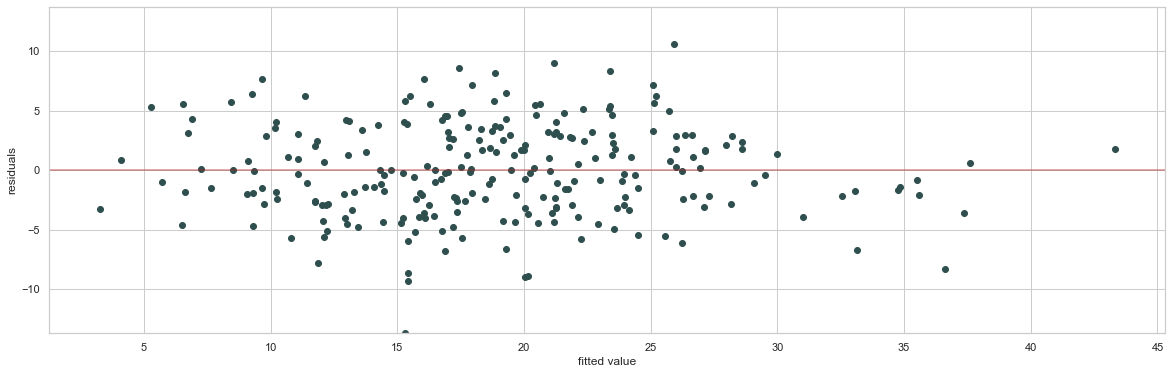

In [56]:
plot_residual(result17)

One of these assumptions of OLS is that our residuals are normally distributed with a mean of 0. This plot tells us we have met this assumption as the distributions is very symmetric.  

Next, let's test our predictions.

In [57]:
predictions = {"Age": "+", "Weight": "+", "Height": "+", "Neck": "+",
               "Hip": "+", "TTH": "+", "Knee": "+",
               "BTH": "+", "FTH": "+", "Wrist": "+",
              "BMI": "+", "ABTH": "+"}
models.evaluate_coefficient_predictions(predictions, result17)

Age P(>0)=0.990 (strong)
Weight P(>0)=0.000 (weak)
Height P(>0)=1.000 (strong)
Neck P(>0)=0.010 (weak)
Hip P(>0)=1.000 (strong)
TTH P(>0)=0.980 (strong)
Knee P(>0)=0.740 (strong)
BTH P(>0)=0.920 (strong)
FTH P(>0)=0.950 (strong)
Wrist P(>0)=0.000 (weak)
BMI P(>0)=0.990 (strong)
ABTH P(>0)=1.000 (strong)


The model agress with most of our predictions, except Neck, Weight and Wrist which fly in the face of logic. As stated, we believe this is due to the mulcolinearity in our model. 

### Model Evaluation

Now that we have selected our final model, let's evaluate it. First we will perform three rounds of 10-fold cross validation, estimating $R^2$ and $\sigma$ each round. We will be using helper functions provided by Lab 11 to accomplish this. 

In [58]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [59]:
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

Let's run `cross_validation` on our model and data:

In [60]:
import patsy

formula = """BodyFat ~ Age + Weight + Height + Neck + Hip + TTH + Knee +
        BTH + FTH + Wrist + BMI + ABTH"""
result = cross_validation(models.linear_regression, formula, bodyfat, lambda r: (r["sigma"], r["r_squared"]))

In the results above, we have the metric ($\sigma$ or $R^2$) and the 95% credible intervals for the *metric*. Now we have 30 estimates of each metric. That's sufficient to estimate credible bounds. We can just get the quantiles. That is, 3 rounds of 10 fold cross validation is already a kind of Bootstrap estimate of the metric:

In [61]:
print(r"95% CI for sigma:", stats.mstats.mquantiles([r[0] for r in result], [0.025, 0.975]))

95% CI for sigma: [4.40492431 7.09341563]


In [62]:
print(r"95% CI for R^2:", stats.mstats.mquantiles([r[1] for r in result], [0.025, 0.975]))

95% CI for R^2: [0.61995151 0.85702889]


The *difference* between the two intervals is that the first Bootstrap results are based on a model evaluated against the data it was tested with whereas the 10 fold cross validation simulates the application of the model against data that was not used to train it. We can see that in both instances, the $\sigma$ and $R^2$ have increased error bounds. In the case of the latter, we've gone from [.70,.80] to [.55,.89], a wide margin!

We can also calculate the *mean* $\sigma$ and $R^2$ and calculate the 95% credible intervals for the *mean* values. This also makes sense. If we want to predict the average mpg, we might want to see the credible intervals for the *average* mpg.

Let's start by seeing what the mean values are:

In [63]:
sigmas = [r[0] for r in result]
r_squareds = [r[1] for r in result]

In [64]:
print("mean sigma: ", np.mean(sigmas))
print("mean R^2: ", np.mean(r_squareds))

mean sigma:  5.558293278972361
mean R^2:  0.7303235771444093


In [65]:
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [66]:
bootstrap = {}
bootstrap["sigma"] = np.array([np.mean(s) for s in [resample(sigmas) for i in range( 0, 1000)]])
bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(r_squareds) for i in range( 0, 1000)]])

In [67]:
print(r"95% CI for *mean* sigma:", stats.mstats.mquantiles(bootstrap["sigma"], [0.025, 0.975]))

95% CI for *mean* sigma: [5.33668494 5.84280566]


In [68]:
print(r"95% CI for *mean* R^2:", stats.mstats.mquantiles(bootstrap["r_squared"], [0.025, 0.975]))

95% CI for *mean* R^2: [0.70252389 0.75616407]


We have medium tight bounds on what we think the average $\sigma$ and $R^2$ are for our model. 

We expect our model to perform OK on untested data. Since the range of $R^2$ is not very close to our initial $R^2$ of .74, our model probably overfits the data.


Let's next use learning curves to see if adding data will improve estimation of the model. Here we want to plot ever increasing chunks of the test data to simulate getting more data. This should/may/could also reveal if we are in a high bias or high variance situation. We will use the helper functions form Lab 11. 

In [69]:
from collections import defaultdict

In [70]:
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [71]:
def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

In [72]:
result = learning_curves(models.linear_regression, formula, bodyfat, lambda r: r["sigma"])

In [73]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [74]:
def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = float( 0.5 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = float( 2.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()
#

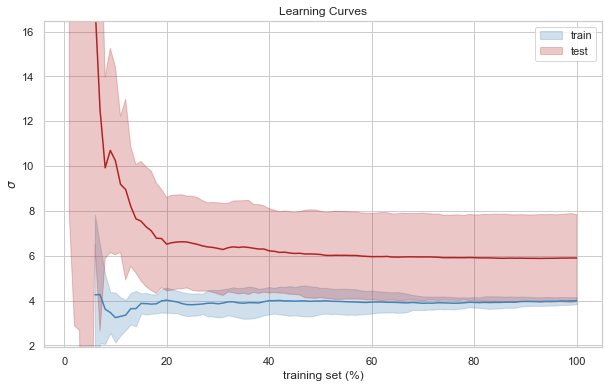

In [75]:
plot_learning_curves(result, r"$\sigma$", zoom = True)

There is a gap between training and testing error. The gap doesn't seem to be narrowing after a certain percetange so we shouldn't expect added data to improve the model. As a result our model seems to suffer from some bias.

### Describe the Model

In [76]:
models.describe_bootstrap_lr(result17)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-231.17,-321.53,-123.14
Age,$\beta_{1}$,0.05,0.00,0.10
Weight,$\beta_{2}$,-0.41,-0.65,-0.11
Height,$\beta_{3}$,0.81,0.21,1.34
Neck,$\beta_{4}$,-0.46,-0.87,-0.06
Hip,$\beta_{5}$,0.51,0.24,0.72
TTH,$\beta_{6}$,38.47,2.34,82.41
Knee,$\beta_{7}$,0.12,-0.31,0.53
BTH,$\beta_{8}$,36.17,-11.54,88.69


Our final model is:

* $x_1$ - Age
* $x_2$ - Weight
* $x_3$ - Height
* $x_4$ - Neck 
* $x_5$ - Hip
* $x_6$ - TTH
* $x_7$ - Knee
* $x_8$ - BTH
* $x_9$ - FTH
* $x_10$ - Wrist
* $x_11$ - BMI
* $x_12$ - ABTH

bodyfat% = -231.17 +.05$x_1$ - .41$x_2$ + .81$x_3$ -.46$x_4$ + .51$x_5$ +38.47$x_6$ + .12$x_7$ + 36.17$x_8$ + 46.07$x_9$ - 1.65$x_w$ + 2.64$x_b$ + 81.09$x_a$

The 'null' model (intercept) is nonexistant person with measurements of size zero.

### Use the Model

We build models for a purpose. One of these purposes might be explanation: we want to try to explain charges.
Another purpose is prediction, we might want to predict a persons's bodyfat %. 

We will use three examples:
1) FF =  31 year old 175 pound 5'10'' with 16 inch neck, hip of 30 inches, thigh of 24 inches, knee of 15 inches, biceps of 15 inches, forearm of 10 inches and wrist of 7 inches, abdomen of 32 inches. 
2) SS =  44 year old 210 pound 5'8'' with 18 inch neck, hip of 28 inches, thigh of 30 inches, knee of 17 inches, biceps of 20 inches, forearm of 11 inches and wrist of 9 inches, abdomen of 40 inches. 
3) AA = 22 year old 190 pound 6'3'' with 16 inch neck, hip of 31 inches, thigh of 26 inches, knee of 15 inches, biceps of 15 inches, forearm of 12 inches and wrist of 8 inches, abdomen of 32 inches. 

Before estimating let's first revist our null model. We estimated bodyfat as:

In [77]:
bodyfat.BodyFat.mean()

18.835458167330682

with an error

In [78]:
bodyfat.BodyFat.std()

7.770856946903798

So we expect a 95% error bounds of our null model to be

In [79]:
[bodyfat.BodyFat.mean()-1.96*bodyfat.BodyFat.std(), bodyfat.BodyFat.mean()+1.96*bodyfat.BodyFat.std()]

[3.6045785513992374, 34.06633778326213]

We estimate body fat to be 18.8% with a range between 3.6% and 34.1%.

Let's start with the FF. 

1) FF =  31 year old 175 pound 5'10'' with 16 inch neck, hip of 30 inches, thigh of 24 inches, knee of 15 inches, biceps of 15 inches, forearm of 10 inches and wrist of 7 inches, abdomen of 32 inches.

Because of the transformations, we'll need to compute them by hand.

In [80]:
FF = [1, 31, 175, 70*2.54, 16*2.54, 30*2.54, 24/70, 15*2.54, 15/70, 10/70, 7*2.54, 703*(175/70/70), 32/30]

In [81]:
prediction = result17["model"].predict([FF])

In [82]:
[prediction[0][0], prediction[0][0]-1.96*result17["sigma"], prediction[0][0]+1.96*result17["sigma"]]

[18.044532921686454, 10.206629772854773, 25.882436070518132]

Our model predicts a Body Fat % of 18% with an error bounds of 10% to essentially 25%. 

Next let's examine SS.

2) SS =  44 year old 210 pound 5'8'' with 18 inch neck, hip of 28 inches, thigh of 30 inches, knee of 17 inches, biceps of 20 inches, forearm of 11 inches and wrist of 9 inches, abdomen of 40 inches.  

In [83]:
SS = [1, 44, 210, 68*2.54, 18*2.54, 28*2.54, 30/68, 17*2.54, 20/68, 11/68, 9*2.54, 703*(210/68/68), 40/28]

In [84]:
prediction = result17["model"].predict([SS])
[prediction[0][0], prediction[0][0]-1.96*result17["sigma"], prediction[0][0]+1.96*result17["sigma"]]

[42.290681900382765, 34.45277875155109, 50.12858504921444]

Our model predicts a bodyfat percentage of 42.3% with error bounds from 34.5% to 50.1%

Last, let's examine AA.

3) AA = 22 year old 150 pound 6'3'' with 16 inch neck, hip of 31 inches, thigh of 26 inches, knee of 15 inches, biceps of 15 inches, forearm of 12 inches and wrist of 8 inches, abdomen of 32 inches. 

3) AA = 22 year old 190 pound 6'3'' with 16 inch neck, hip of 31 inches, thigh of 26 inches, knee of 15 inches, biceps of 15 inches, forearm of 12 inches and wrist of 8 inches, abdomen of 32 inches. 

In [85]:
AA = [1, 22, 190, 73*2.54, 16*2.54, 31*2.54, 26/73, 15*2.54, 15/73, 12/73, 8*2.54, 703*(190/73/73), 32/31]

In [86]:
prediction = result17["model"].predict([AA])
[prediction[0][0], prediction[0][0]-1.96*result17["sigma"], prediction[0][0]+1.96*result17["sigma"]]

[12.976541834833185, 5.138638686001505, 20.814444983664863]

Our model predicts a bodyfat percentage of 13.0% with error bounds from  5.1% to 20.8%

The three estimates have much tighter estimates than the null model, which basically covers the entire length of possible body fats. 

We note also that despite our best efforts we still have a large error range. (The difference between 5% body fat and 21% is very noticeable). It's notoriously difficult to use circumference to measure body fat since it just doesn't exist under the skin but also between organs. This "visceral" body fat is therefore undetectable by circumference measurement. The best model would never be able to capture this.

### Just for Fun

On a final note, the best model that the [Navy](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4831679/) uses, when applied to our model still results in a larger $\sigma$ than our model, however, theres may not be as biased as ours. For fun, let's apply their model to our data set and compare. According to the website, 
* BodyFat % = 495/(1.0324 - 0.19077 * log10(waist - neck) + 0.15456 * log10(height)) - 450, where abdomen, neck and height are in cm.

In [87]:
bodyfat["bf_navy_prediction"] = 495/(1.0324 - 0.19077 * np.log10(bodyfat.Abdomen - bodyfat.Neck) 
                                     + 0.15456 * np.log10(bodyfat.Height)) - 450
error = bodyfat.BodyFat - bodyfat.bf_navy_prediction
error[0:10]

0   -6.364172
1   -6.663255
2    1.422203
3   -6.154111
4   -0.587153
5    0.444013
6   -2.895285
7   -5.499966
8   -7.686235
9   -2.647170
dtype: float64

Now let's find the coefficient of variation.

In [88]:
1 - np.sum(error**2)/np.sum((bodyfat.BodyFat - np.mean(bodyfat.BodyFat))**2)

0.60331654450824

Applied to our data, the Navy's model has a $R^2$ of 60%. Let's check their $\sigma$. So our model beats the Navy's by about 10-15%. However, the Navy's model is probably not as biased as ours.